In [ ]:
! git clone https://github.com/mogwai/fastai_audio.git

Cloning into 'fastai_audio'...
remote: Enumerating objects: 1490, done.
remote: Counting objects: 100% (39/39), done.
remote: Compressing objects: 100% (34/34), done.
remote: Total 1490 (delta 17), reused 16 (delta 5), pack-reused 1451
Receiving objects: 100% (1490/1490), 161.64 MiB | 5.62 MiB/s, done.
Resolving deltas: 100% (908/908), done.


In [ ]:
pip install torchaudio

     |████████████████████████████████| 1.9 MB 7.4 MB/s 


In [ ]:
import sys
sys.path.append('..')
from fastai.vision import *
from fastai_audio.audio import *
import matplotlib.pyplot as plt
import math

**Introduction to Audio For FastAI Students**

In [ ]:
data_url = 'http://www.openslr.org/resources/45/ST-AEDS-20180100_1-OS'
data_folder = datapath4file(url2name(data_url))
if not os.path.exists(data_folder): untar_data(data_url, dest=data_folder)

In [ ]:
from IPython.display import Audio
audio_files = data_folder.ls()
example = audio_files[0]
Audio(str(example))

**Basics of Librosa, audio signals, and sampling**

In [ ]:
import librosa

In [ ]:
y, sr = librosa.load(example, sr=None)

In [ ]:
print("Sample rate  :", sr)
print("Signal Length:", len(y))
print("Duration     :", len(y)/sr, "seconds")

Sample rate  : 16000
Signal Length: 76800
Duration     : 4.8 seconds


In [ ]:
print("Type  :", type(y))
print("Signal: ", y)
print("Shape :", y.shape)

Type  : <class 'numpy.ndarray'>
Signal:  [ 0.000000e+00  0.000000e+00  0.000000e+00  0.000000e+00 ... -2.441406e-04 -2.746582e-04 -6.103516e-05 -2.746582e-04]
Shape : (76800,)


In [ ]:
Audio(y, rate=sr)

Before running and listening to the cells below, think about the concept of sampling rate and try to predict what effect the varying sample rates will have

In [ ]:
Audio(y, rate=sr/2)

In [ ]:
Audio(y, rate=sr*2)

In [ ]:
y_new, sr_new = librosa.load(example, sr=sr*2)
Audio(y_new, rate=sr_new)

In [ ]:
y_new, sr_new = librosa.load(example, sr=sr/2)
Audio(y_new, rate=sr_new)

**Waveforms, amplitude vs magnitude**

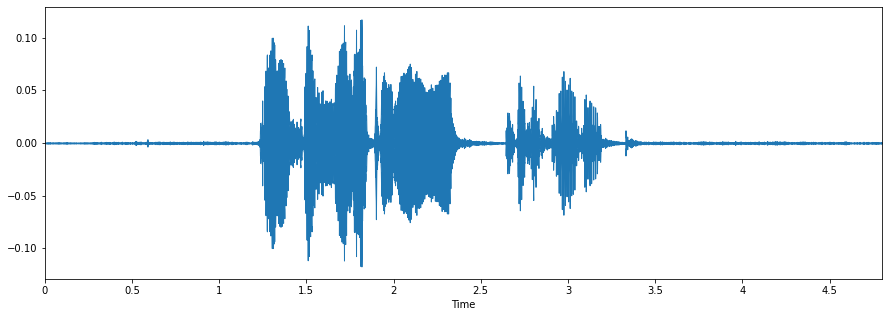

In [ ]:
import librosa.display
plt.figure(figsize=(15, 5))
librosa.display.waveplot(y, sr=sr)

**Frequency and Pitch**

In [ ]:
# Adapted from https://musicinformationretrieval.com/audio_representation.html
# An amazing open-source resource, especially if music is your sub-domain.
def make_tone(freq, clip_length=1, sr=16000):
    t = np.linspace(0, clip_length, int(clip_length*sr), endpoint=False)
    return 0.1*np.sin(2*np.pi*freq*t)
clip_500hz = make_tone(500)
clip_5000hz = make_tone(5000)

In [ ]:
Audio(clip_500hz, rate=sr)

In [ ]:
Audio(clip_5000hz, rate=sr)

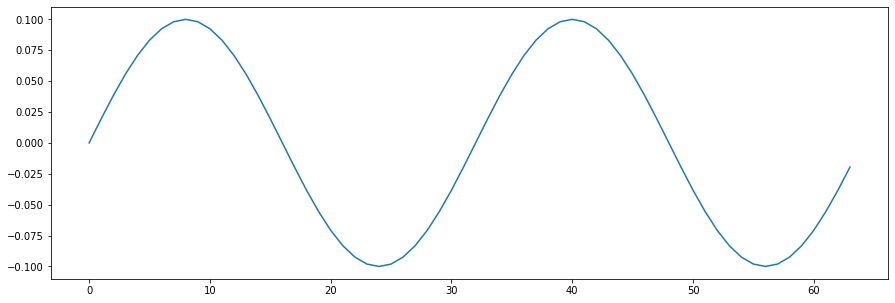

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(clip_500hz[0:64])

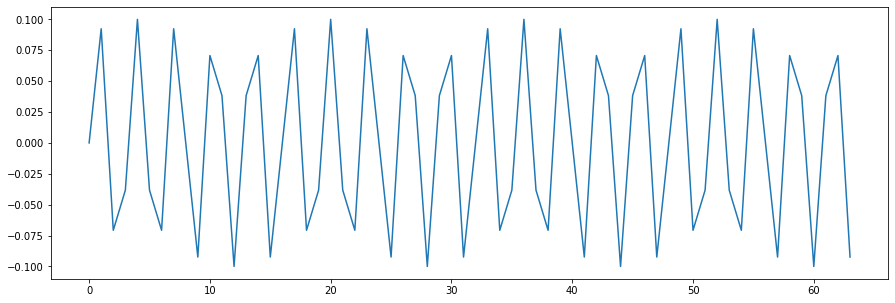

In [ ]:
plt.figure(figsize=(15, 5))
plt.plot(clip_5000hz[0:64])

In [ ]:
clip_500_to_1000 = np.concatenate([make_tone(500), make_tone(1000)])
clip_5000_to_5500 = np.concatenate([make_tone(5000), make_tone(5500)])

In [ ]:
# first half of the clip is 500hz, 2nd is 1000hz
Audio(clip_500_to_1000, rate=sr)

In [ ]:
# first half of the clip is 5000hz, 2nd is 5500hz
Audio(clip_5000_to_5500, rate=sr)

**Mel scale**

The mel scale is a human-centered metric of audio perception that was developed by asking participants to judge how far apart different tones were. Here is a formula from mel-scale's wikipedia page that you will never need, but might like to see.

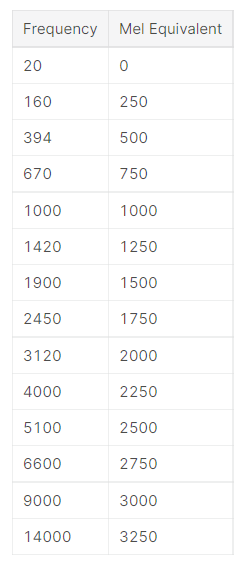

When we visually represent audio using spectrograms, we will use the mel scale instead of frequency on our y-axis, so that our data is reshaped to mirror human perception. If you're getting bored, hang in there, because we are so close to the fun part (spectrograms), but there is one last piece to human hearing puzzle we need to deal with.

**Decibels**

Just like frequency, human perception of loudness occurs on a logarithmic scale. A constant increase in the amplitude of a wave will be perceived differently if the original sound is soft or loud.

Decibels measure the ratio of power between 2 sounds, with the main idea being that each 10x increase in the energy of the wave (multiplicative) results in a 10dB increase in sound (additive). Thus something that is 20dB louder has 100x (10*10) the amount of energy, something that is 25dB louder has (10^2.5) = 316.23x more energy.

The lowest audible sound, near absolute silence, is 0dB and we refer to other sounds based on how many times more energy they have than a 0dB sound. A dishwasher is ~30dB, or 10^3 = 1000x louder. Here is a nice chart taken from: https://boomspeaker.com/noise-level-chart-db-level-chart/

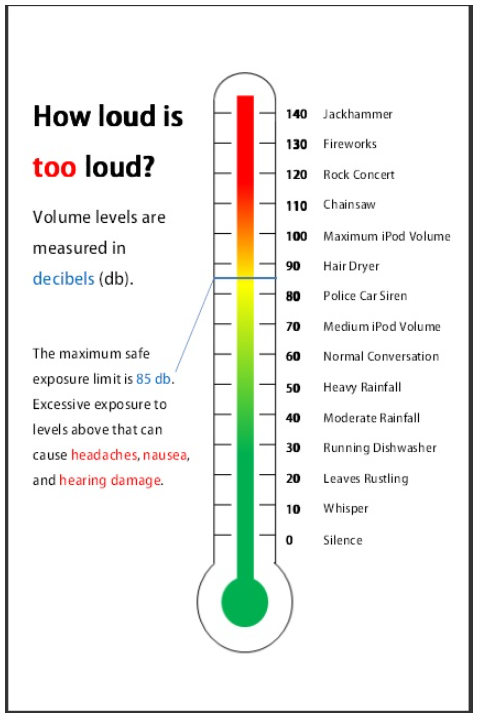

The range of human perception is vast, from a base of 0dB up to 100dB (an amount that will damage your hearing), is a range of 10^10, or 10,000,000,000x. A doubling of energy will only increase the dB level by ~3dB. If we don't use a logarithmic scale, we would squish whispers and rustling leaves, and even normal conversation out of existence. Thus is it is important that we measure our spectrograms be on the decibel scale for most of our applications.

Deep dive for decibel scale: http://www.animations.physics.unsw.edu.au/jw/dB.htm

**Spectrogram as a visual representation of audio**

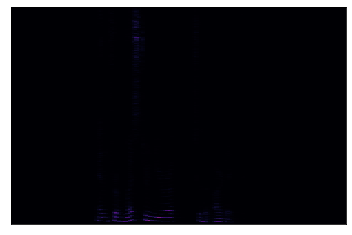

In [ ]:
sg0 = librosa.stft(y)
sg_mag, sg_phase = librosa.magphase(sg0)
display(librosa.display.specshow(sg_mag))

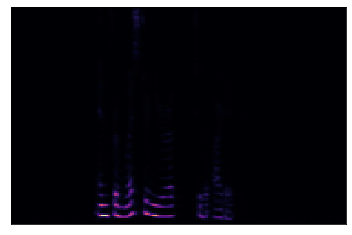

In [ ]:
sg1 = librosa.feature.melspectrogram(S=sg_mag, sr=sr)
display(librosa.display.specshow(sg1))

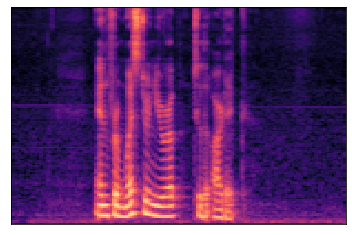

In [ ]:
sg2 = librosa.amplitude_to_db(sg1, ref=np.min)
librosa.display.specshow(sg2)
#20 * log10(S / ref)

In [ ]:
print("max db {}".format(20*np.log10(np.max(sg1)/np.min(sg1))))
print("min db {}".format(20*np.log10(1)))

max db 81.40131950378418
min db 0.0


**What's inside a spectrogram**

Text(0.5, 1.0, 'Mel spectrogram')

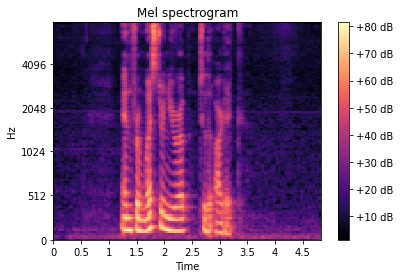

In [ ]:
# code adapted from the librosa.feature.melspectrogram documentation
librosa.display.specshow(sg2, sr=16000, y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('Mel spectrogram')

In [ ]:
sg2.min(), sg2.max(), sg2.mean()

(1.4013138, 81.40131, 21.42888)

In [ ]:
print(type(sg2))
sg2.shape

<class 'numpy.ndarray'>


(128, 151)

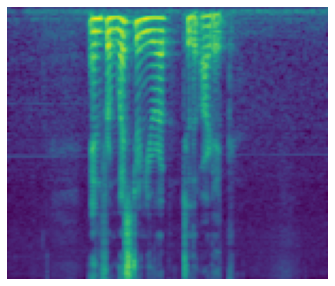

In [ ]:
Image.show(torch.from_numpy(sg2).unsqueeze(0), figsize=(15, 5), cmap=None)

In [ ]:
torch.from_numpy(sg2).unsqueeze(0).shape

torch.Size([1, 128, 151])

**Spectrogram parameters and how to fine tune them for deep learning**

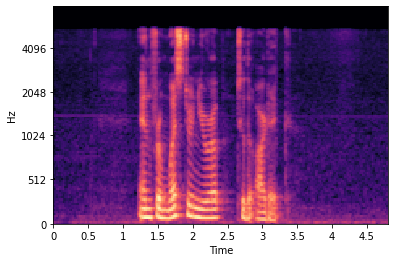

In [ ]:
y, sr = librosa.load(example)
display(Audio(y, rate=sr))
sg = librosa.feature.melspectrogram(y, sr=16000,  n_fft=2048, hop_length=512, power=1.0, n_mels=128, fmin=0.0, fmax=None)
db_spec = librosa.amplitude_to_db(sg, ref=1.0, amin=1e-05, top_db=80.0)
librosa.display.specshow(db_spec, y_axis='mel', fmax=8000, x_axis='time')

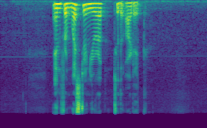

In [ ]:
Image(torch.from_numpy(db_spec).unsqueeze(0))

**Fourier Transforms**

In [ ]:
# Adapted from https://musicinformationretrieval.com/audio_representation.html
# An amazing open-source resource, especially if music is your sub-domain.
def make_tone(freq, clip_length=1, sr=16000):
    t = np.linspace(0, clip_length, int(clip_length*sr), endpoint=False)
    return 0.1*np.sin(2*np.pi*freq*t)

In [ ]:
def add_3_random_tones(clip_length=1, sr=16000):
    tone_list = []
    for i in range(3):
        frequency = random.randint(500,8000)
        tone_list.append(make_tone(frequency, clip_length, sr))
        print(f"Frequency {i+1}: {frequency}")
    return sum(tone_list)

In [ ]:
sr = 16000
signal = add_3_random_tones(sr=sr)

Frequency 1: 3529
Frequency 2: 6636
Frequency 3: 2441


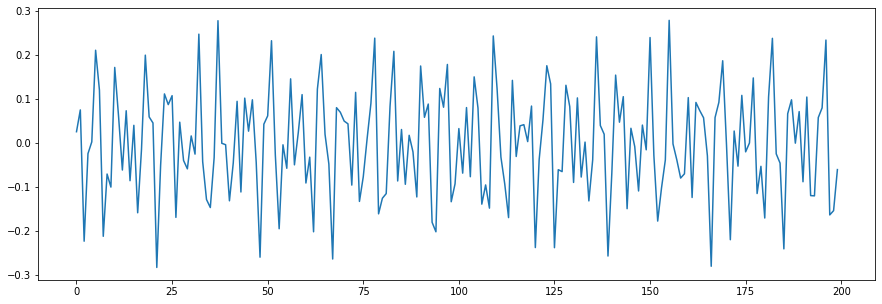

In [ ]:
display(Audio(signal, rate=sr))
plt.figure(figsize=(15, 5))
plt.plot(signal[200:400])

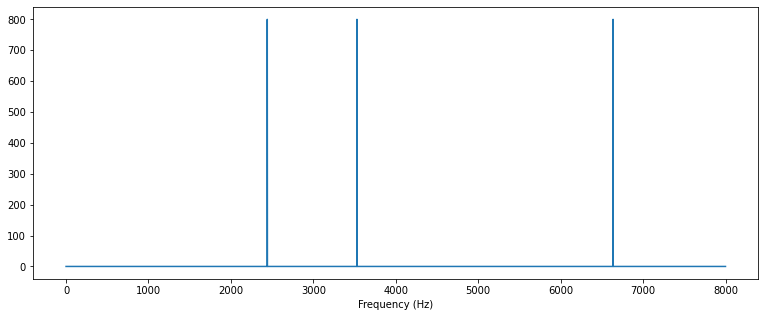

In [ ]:
# Code adapted from https://musicinformationretrieval.com/fourier_transform.html and the original
# implementation of fastai audio by John Hartquist at https://github.com/sevenfx/fastai_audio/
def fft_and_display(signal, sr):
    ft = scipy.fftpack.fft(signal, n=len(signal))
    ft = ft[:len(signal)//2+1]
    ft_mag = np.absolute(ft)
    f = np.linspace(0, sr/2, len(ft_mag)) # frequency variable
    plt.figure(figsize=(13, 5))
    plt.plot(f, ft_mag) # magnitude spectrum
    plt.xlabel('Frequency (Hz)')
    
fft_and_display(signal, sr)

In [ ]:
for i in range(5):
    signal += add_3_random_tones(sr=sr)

Frequency 1: 1941
Frequency 2: 6699
Frequency 3: 6063
Frequency 1: 3890
Frequency 2: 2408
Frequency 3: 1421
Frequency 1: 6576
Frequency 2: 1383
Frequency 3: 7003
Frequency 1: 6140
Frequency 2: 5352
Frequency 3: 6046
Frequency 1: 7505
Frequency 2: 5535
Frequency 3: 3965


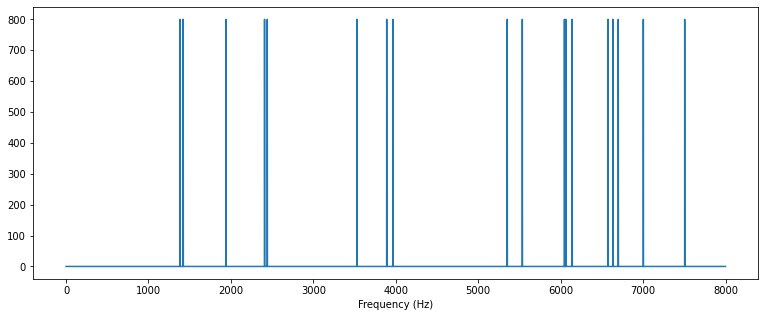

In [ ]:
fft_and_display(signal, sr)

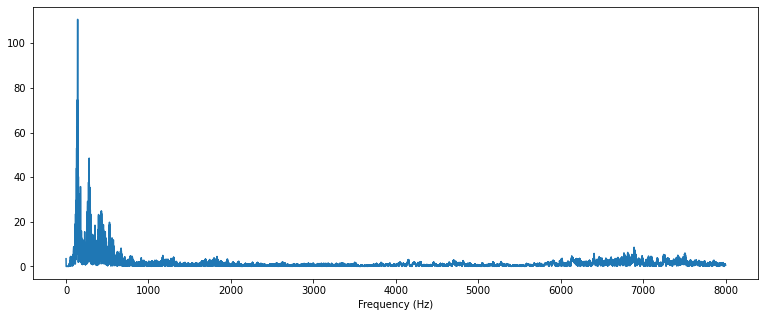

In [ ]:
y, sr = librosa.load(example, sr=16000)
fft_and_display(y, sr)

In [ ]:
s1 = add_3_random_tones(sr=sr)
s2 = add_3_random_tones(sr=sr)
s1_plus_s2 = np.add(s1, s2)
s1_then_s2 = np.concatenate([s1, s2])
display(Audio(s1_plus_s2, rate=sr))
display(Audio(s1_then_s2, rate=sr))

Frequency 1: 6737
Frequency 2: 7356
Frequency 3: 3312
Frequency 1: 4437
Frequency 2: 4660
Frequency 3: 5884


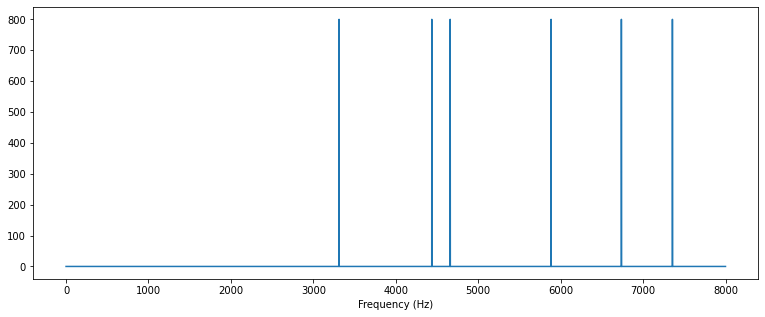

In [ ]:
fft_and_display(s1_plus_s2, sr)

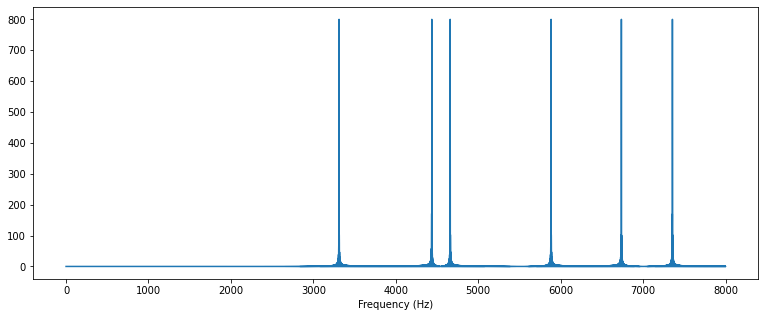

In [ ]:
fft_and_display(s1_then_s2, sr)

**Short-time fourier transform**

The main idea behind the short-time fourier transform is that, instead of doing an FT on the entire signal, we break the signal up into chunks, and compute the FT of each chunk to see how the frequencies of the signal are changing over time.

The demonstration below allows us to distinguish between the signals above in a way that a normal fourier transform could not. Don't worry about understanding code here, we will break it down later to learn what everything does.

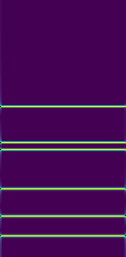

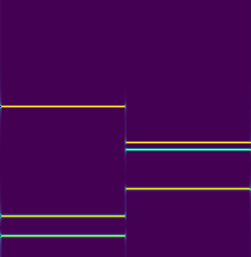

In [ ]:
def stft_and_display(signal, n_fft=512, hop_length=128, to_db_scale=False, n_mels=128, mel_scale=False, 
                     top_db=80, show_shape=False):
    stft = librosa.stft(signal, n_fft, hop_length)
    real_portion = abs(stft)
    if(mel_scale):   real_portion = librosa.feature.melspectrogram(S=real_portion, n_fft=n_fft, n_mels=n_mels)
    if(to_db_scale): real_portion = librosa.amplitude_to_db(real_portion, top_db)
    if(show_shape):  print("Shape: {}x{}".format(*real_portion.shape))
    display(Image(torch.from_numpy(real_portion).unsqueeze(0)))
display(Audio(s1_plus_s2, rate=sr))    
stft_and_display(s1_plus_s2)
display(Audio(s1_then_s2, rate=sr))    
stft_and_display(s1_then_s2)

To understand exactly what is happening inside the STFT, let's start playing with our first spectrogram parameters, n_fft, and hop_length.

**n_fft and hop_length**

The best way to understand what changes will happen as you mess with these variables, is to mess with these variables and see what happens. First at a base level by looking at the spectrograms and trying to understand and then actually try training one of the audio datasets, but seeing how changing a variable like n_fft or hop_length (while keeping everything else the same) impacts training, in the same way that you do with normal ML hyperparams like learning rate or image_size.

n_fft = 100


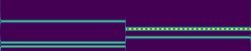

n_fft = 600


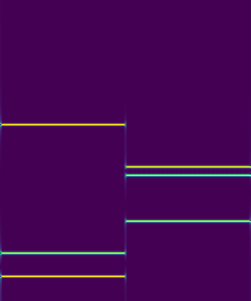

n_fft = 1100


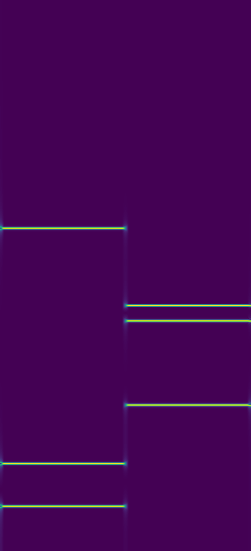

n_fft = 1600


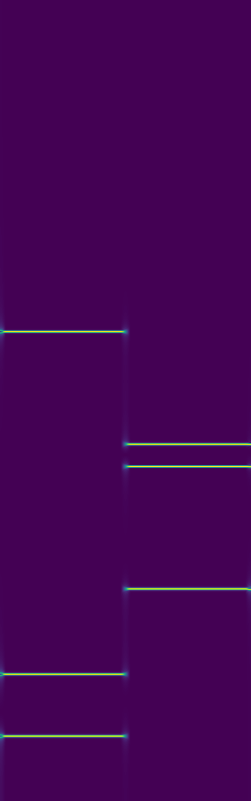

In [ ]:
for n_fft in range(100, 2100, 500):
    print("n_fft =", n_fft)
    stft_and_display(s1_then_s2, n_fft=n_fft)

The n_fft is making our images taller, and more spaced out, but the bars for an individual frequency remain the same size. Thus when we increase n_fft in our stft, we have more resolution in the frequency dimension, and can distinguish between more possible frequencies. If we set the n_fft too low, they all get smashed together. Let's try again with our real world speech data, this time narrowing the range to lower values so we can more easily see the impact

n_fft = 50


n_fft = 250


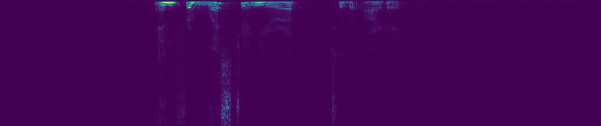

n_fft = 450


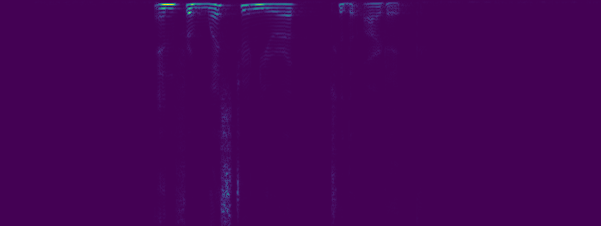

n_fft = 650


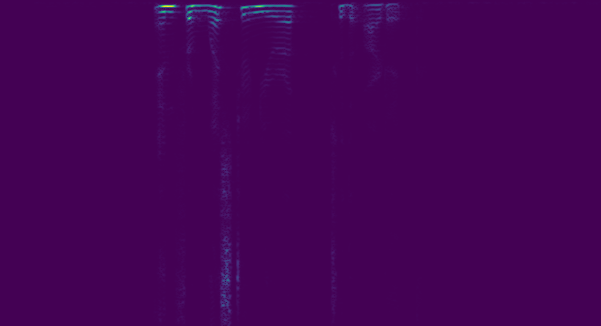

n_fft = 850


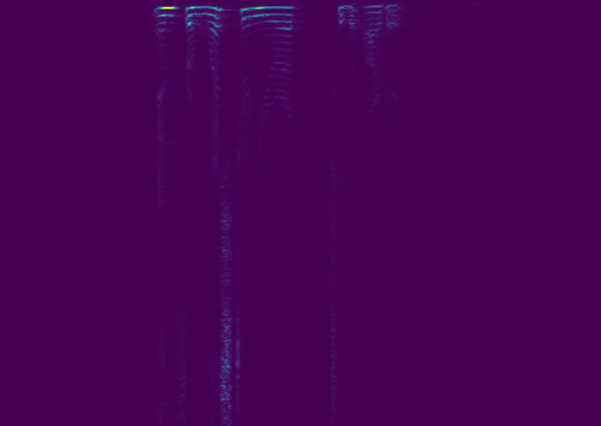

In [ ]:
y, sr = librosa.load(example, sr=16000)
for n_fft in range(50, 1050, 200):
    print("n_fft =", n_fft)
    stft_and_display(y, n_fft=n_fft)

Since real speech has more frequencies, having too low an n_fft causes us to lose info about which frequencies are present. It looks like around an n_fft of 350-450, we aren't losing any info, but if we reshape the data to mimic human hearing, converting again to the mel scale for frequency, and decibels for loudness, it becomes clear we weren't getting the whole picture (and neither was our image classifier that will be learning from these spectrograms)

n_fft = 50


/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


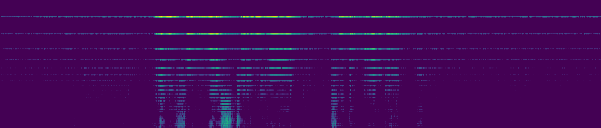

n_fft = 250


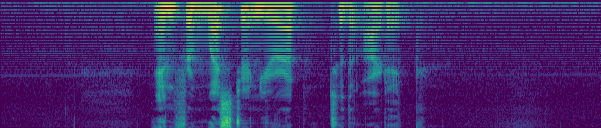

n_fft = 450


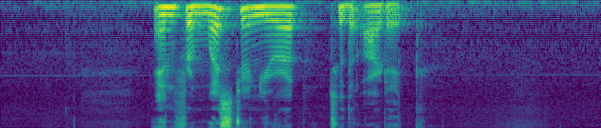

n_fft = 650


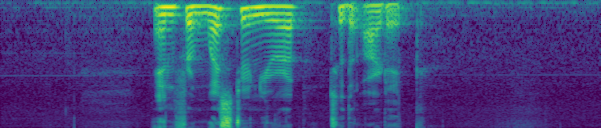

n_fft = 850


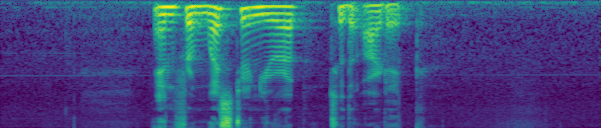

In [ ]:
for n_fft in range(50, 1050, 200):
    print("n_fft =", n_fft)
    stft_and_display(y, n_fft=n_fft, mel_scale=True, to_db_scale=True)

Notice that our images are no longer ballooning in length as we increase n_fft. In fact, they aren't changing at all. This is due to the way melspectrograms are constructed, and somethign we'll cover later in the 'n_mels' section. If you go back and try it again with mel_scale=False, you'll see that they still stretch, but what appears to be additional information that we are losing on the mel_scale is actually information that is disproportionately unimportant to discriminating between sounds that we care about.

Yes, we will lose the ability to differentiate between an 8050hz sound and an 8060hz sound, but this is an ability that humans don't have and will never impact your models accuracy on a human-centric problem like speech-recognition. That being said, keep in mind that if your application does depend on being able to differentiate between sounds in a way that a human cannot, the mel-scale might not be a good idea.

Now we do the same with hop_length, using an n_fft of 850.

hop_length = 50


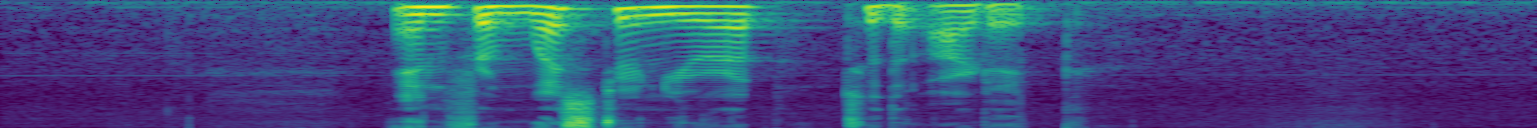

hop_length = 150


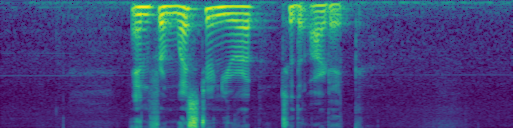

hop_length = 250


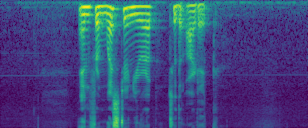

hop_length = 350


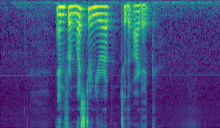

hop_length = 450


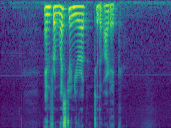

In [ ]:
for hop_length in range(50, 550, 100):
    print("hop_length =", hop_length )
    stft_and_display(y, n_fft=850, hop_length=hop_length, mel_scale=True, to_db_scale=True)

So hop_length does something to alter the width of the spectrogram. This is good to know, but since image size can be really important to training, I'm going to show you exactly how you can control the width of your spectrogram images.

Sig length   : 76800
hop_length   : 100
SigLen/HopLen: 768.0
Floor + 1    : 769
Shape: 128x769


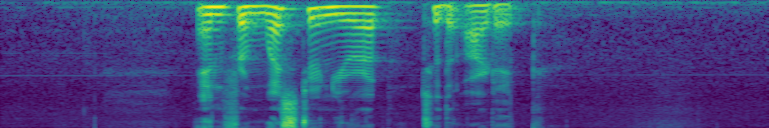

Sig length   : 76800
hop_length   : 200
SigLen/HopLen: 384.0
Floor + 1    : 385
Shape: 128x385


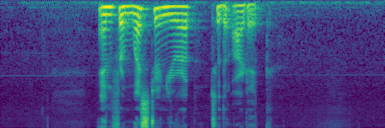

Sig length   : 76800
hop_length   : 300
SigLen/HopLen: 256.0
Floor + 1    : 257
Shape: 128x257


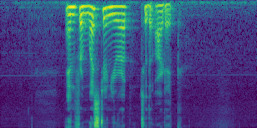

Sig length   : 76800
hop_length   : 400
SigLen/HopLen: 192.0
Floor + 1    : 193
Shape: 128x193


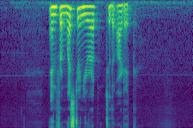

In [ ]:
for hop_length in range(100, 500, 100):
    print("Sig length   :", len(y))
    print("hop_length   :", hop_length)
    print("SigLen/HopLen:", len(y)/hop_length)
    print("Floor + 1    :", int(len(y)/hop_length)+1)
    stft_and_display(y, n_fft=850, hop_length=hop_length, mel_scale=True, to_db_scale=True, show_shape=True)

I don't have fancy LaTeX for this but the python version is

spectrogram_width = math.floor(len(signal)/hop)+1

also keeping in mind that

len(signal) = duration*sample_rate #duration in seconds

With this, you can take any length signal (fastai audio has built in features to remove silence, segment, and pad signals to a fixed length) and

**Full explanation of STFT, hop_length, and n_fft**

Remember how we wanted to split a signal into chunks, and then compute the fourier transform of each chunk to see how the frequencies were changing over time? The STFT is taking your signal and splitting it into those chunks. Hop_length is the size (in number of samples) of those chunks. If you set hop_length to 100, the STFT will divide your 52,480 sample long signal into 525 chunks, compute the FFT (fast fourier transform, just an algorithm for computing the FT of a discrete signal) of each one of those chunks.

The output of each FFT will be a 1D tensor with n_fft # of values, each value is the magnitude of the energy for a particular range of frequencies, at that chunk of time. For example, if our min and max frequencies (something we havent covered yet) are set to 0hz and 8000hz, and my n_fft is 100, every FFT will chop that frequency range into 100 baskets, 0-80hz, 80-160hz, 160-240hz...7920hz-8000hz, and will then perform an fft on each chunk of 100 samples, and will return a 1D tensor where the first value is the magnitude of the energy in the 0-80hz range for the first 100 samples, the second value is the energy in the 80-160hz range for the first 100 samples and so on. That tensor is then rotated and becomes the first column of our STFT image. If you are not using the mel_scale, you will have n_fft as the height of your images, but if you are using the mel-scale, the height of your image will be determined by the number of mel filters you use, the parameter n_mels, something that is much simpler than it sounds, and that we will discuss next

**n_mels**

Each melspectrogram in the last section was 128 pixels tall. That's because, by default, we set n_mels to 128. Let's try with n_mels what we did for n_fft and hop_length to see what effect it has.

A random tip is that n_fft will be fastest when it is a power of 2 and slowest when it's prime, so convention is to just use powers of 2. Let's set that to 2^10 = 1024. What should our hop be? Let's do 2^8 = 256 for now until we figure out what impact n_mels has.

n_mels = 50
Shape: 50x301


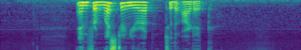

n_mels = 300
Shape: 300x301


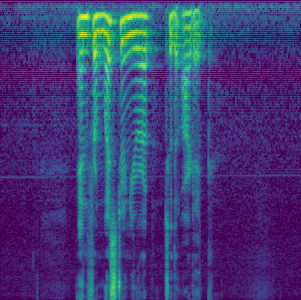

n_mels = 550
Shape: 550x301


/usr/local/lib/python3.7/dist-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


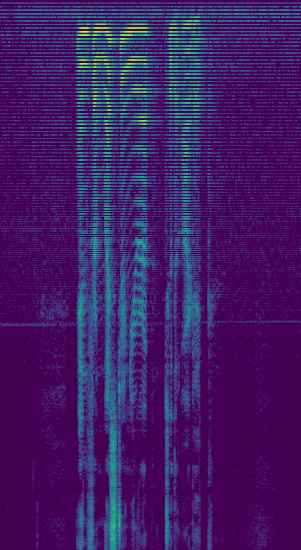

n_mels = 800
Shape: 800x301


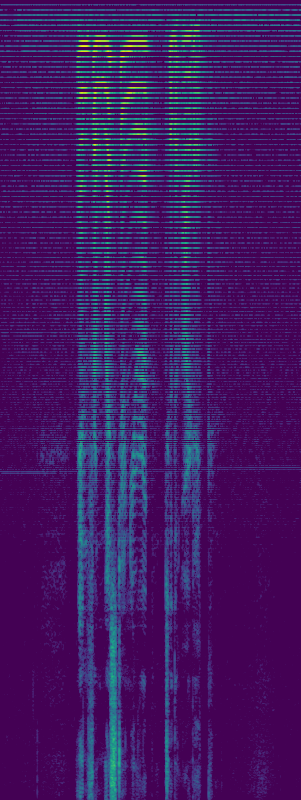

In [ ]:
for n_mels in range(50, 1050, 250):
    print("n_mels =", n_mels)
    stft_and_display(y, n_fft=1024, hop_length=256, n_mels=n_mels, mel_scale=True, to_db_scale=True, show_shape=True)

So the height in pixels of our image is always equal to n_mels when we compute a mel-spectrogram(and is equal to n_fft when we don't use the mel scale). If you scroll down, you'll see that we have a lot of black bars when we have too many mels. This is because when librosa converts a spectrogram to the melscale, there are points where it doesn't have enough data from the linear scaled fft buckets to fill in the logarithmically scaled mel buckets. If we increase n_fft, they will go away, but not without a cost.

n_mels = 50
Shape: 50x301


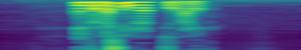

n_mels = 300
Shape: 300x301


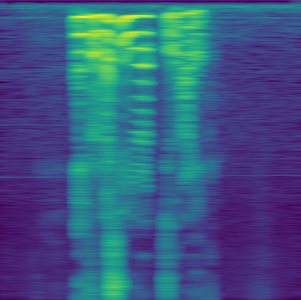

n_mels = 550
Shape: 550x301


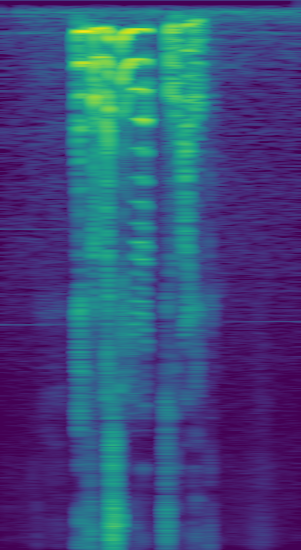

n_mels = 800
Shape: 800x301


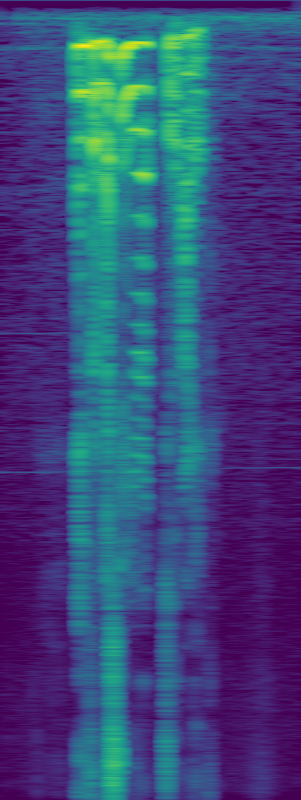

In [ ]:
for n_mels in range(50, 1050, 250):
    print("n_mels =", n_mels)
    stft_and_display(y, n_fft=8192, hop_length=256, n_mels=n_mels, mel_scale=True, to_db_scale=True, show_shape=True)

When we increase resolution in the frequency dimension (y-axis), we lose resolution in the time dimension, so there is an inherent tradeoff between the choices you make for n_fft, n_mels, and your hop_length. This is getting to the limits of my understanding, so if you feel you can explain this precisely, message me or post in the FastAI Audio Thread

If not, just know that you can control the height of your images by setting the number of mel filters via the n_mels argument to librosa.feature.melspectrogram or if you are using fastai audio, setting the n_mels parameter in your spectrogram config.